In [30]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from ast import literal_eval

# Gensim
from gensim.models import KeyedVectors

# Keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping

# TensorFlow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import legacy

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Membaca data
train_data = pd.read_csv('../../../../Data/5. Split/over/train_data_90_10_over.csv')
validation_data = pd.read_csv('../../../../Data/5. Split/over/validation_data_90_10_over.csv')
test_data = pd.read_csv('../../../../Data/5. Split/over/test_data_90_10_over.csv')

"""
Bagian kode ini membaca tiga dataset yang berbeda dari file CSV dan menyimpannya dalam variabel masing-masing.

In [32]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data['text_tokenize'].apply(literal_eval)
y_train = train_data.label

x_validation = validation_data['text_tokenize'].apply(literal_eval)
y_validation = validation_data.label

x_test = test_data['text_tokenize'].apply(literal_eval)
y_test = test_data.label

"""
Kode ini memisahkan fitur ('text_tokenize') dan label ('label') untuk setiap bagian dataset. 
Fungsi literal_eval digunakan untuk mengubah representasi string dari list menjadi list aktual di Python.

Word2Vec

In [33]:
# Memuat model Word2Vec CBOW yang telah disimpan
model_ug_cbow = KeyedVectors.load('../../../../Model/w2v_model_ug_cbow.word2vec')

# Memuat model Word2Vec Skip-gram yang telah disimpan
model_ug_sg = KeyedVectors.load('../../../../Model/w2v_model_ug_sg.word2vec')

In [34]:
# Menghitung jumlah kata unik dalam model Word2Vec CBOW
unique_words_count = len(model_ug_cbow.wv.index_to_key)

# Menampilkan jumlah kata unik
print(unique_words_count)

7349


In [35]:
embeddings_index = {}

# Menggabungkan kedua embeddings dari model CBOW dan Skip-gram untuk setiap kata unik
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

# Menampilkan jumlah vektor kata yang ditemukan
print('Found %s word vectors.' % len(embeddings_index))

"""
Bagian ini membuat sebuah dictionary untuk menyimpan vektor embedding kata dari kedua model Word2Vec. 
Kemudian, mencetak jumlah vektor kata yang ditemukan.

Found 7349 word vectors.


In [36]:
# Membuat tokenizer dengan jumlah kata maksimum 
tokenizer = Tokenizer(num_words=unique_words_count)  # num_words adalah jumlah kosakata yang ingin digunakan

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

"""
Bagian ini membuat tokenizer, melatihnya pada teks dari data latih dan mengonversi teks menjadi urutan bilangan bulat 
yang merepresentasikan indeks kata.

In [37]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x))

# length berisi panjang (jumlah kata) dari setiap teks dalam data latih

"""
Bagian ini menghitung jumlah kata dalam setiap teks dari data latih dan menghitung jumlah kata maksimum dalam satu kalimat.

In [38]:
# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

# Menampilkan jumlah kata maksimum
print("Maximum number of words in a sentence:", max_word_count)

Maximum number of words in a sentence: 440


In [39]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = max_word_count

# max_len digunakan untuk membatasi panjang urutan maksimum saat melakukan padding

In [40]:
# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

# Menampilkan bentuk tensor data latih yang telah dipad (x_train_seq)
print('Shape of padded data tensor:', x_train_seq.shape)

"""
Bagian ini menetapkan panjang maksimum urutan untuk padding dan melakukan padding pada urutan data latih agar 
semua memiliki panjang yang sama. Kemudian, mencetak bentuk tensor data latih yang telah dipad.

Shape of padded data tensor: (7087, 440)


In [41]:
# Mengonversi teks dalam data validation (x_validation) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_validation)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_validation_seq = pad_sequences(sequences_val, maxlen=max_len)

# Komentar: Sekarang, x_validation_seq berisi data validasi yang telah dipad dan siap digunakan

"""
Bagian ini mengonversi teks dalam data validasi menjadi urutan angka dan melakukan 
padding agar memiliki panjang yang sama dengan data latih.

In [42]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

# Membuat matriks embedding kosong dengan bentuk (num_words, 300)
embedding_matrix = np.zeros((num_words, 300))

# Mengisi matriks embedding dengan vektor embedding yang sesuai dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Komentar: embedding_matrix sekarang berisi vektor embedding untuk seluruh kata unik dalam tokenizer.word_index


"""
Bagian ini menetapkan jumlah kata yang akan digunakan dalam matriks embedding, membuat matriks embedding kosong, 
dan mengisi matriks tersebut dengan vektor embedding yang sesuai.

In [43]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_validation_cat = to_categorical(y_validation + 1, num_classes=3)

"""
Bagian ini mengubah label ke dalam bentuk one-hot encoding untuk proses klasifikasi multi kelas.

Pemodelan LSTM

In [44]:
# Mengatur learning rate dalam pengoptimal Adam: menentukan sejauh mana bobot model diperbarui pada setiap langkah pembelajaran
Adam = legacy.Adam(learning_rate=0.001)

# Menetapkan label smoothing dalam fungsi loss: membuat model lebih robust terhadap label yang salah atau noise dalam data
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Menetapkan callback EarlyStopping: menghentikan pelatihan jika metrik yang dipantau acc tidak meningkat setelah 3 epoch, dan mengembalikan bobot model ke bobot dengan nilai terbaik.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [45]:
# Membuat model Sequential: model dasar yang menumpuk layer dalam urutan linear
model_lstm = Sequential()

# Menambahkan lapisan Embedding: mengubah kata-kata menjadi vektor berkelanjutan
model_lstm.add(Embedding(num_words, 300, input_length=max_len))

# Menambahkan lapisan Dropout: mengurangi overfitting dengan menonaktifkan secara acak beberapa neuron
model_lstm.add(Dropout(0.4))

# Menambahkan lapisan LSTM: layer yang digunakan untuk mempelajari ketergantungan waktu dari data
model_lstm.add(LSTM(150))

# Menambahkan lapisan Dropout: mengurangi overfitting dengan menonaktifkan secara acak beberapa neuron
model_lstm.add(Dropout(0.4))

# Menambahkan lapisan Dense (output): layer output untuk klasifikasi multi-kelas
model_lstm.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_lstm.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])

# Menampilkan ringkasan model
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 440, 300)          2106600   
                                                                 
 dropout_2 (Dropout)         (None, 440, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               270600    
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 453       
                                                                 
Total params: 2,377,653
Trainable params: 2,377,653
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Melatih model dengan data latih dan validasi (gunakan y_train_cat dan y_validation_cat untuk label one-hot encoded)
history_model = model_lstm.fit(x_train_seq, y_train_cat, validation_data=(x_validation_seq, y_validation_cat), epochs=10, batch_size=128, callbacks=[callback], verbose=2)

Epoch 1/10
56/56 - 68s - loss: 0.9253 - accuracy: 0.6046 - val_loss: 0.7274 - val_accuracy: 0.7690 - 68s/epoch - 1s/step
Epoch 2/10
56/56 - 67s - loss: 0.6084 - accuracy: 0.8374 - val_loss: 0.6109 - val_accuracy: 0.8173 - 67s/epoch - 1s/step
Epoch 3/10
56/56 - 69s - loss: 0.4911 - accuracy: 0.9074 - val_loss: 0.5712 - val_accuracy: 0.8579 - 69s/epoch - 1s/step
Epoch 4/10
56/56 - 70s - loss: 0.4301 - accuracy: 0.9440 - val_loss: 0.5621 - val_accuracy: 0.8731 - 70s/epoch - 1s/step
Epoch 5/10
56/56 - 73s - loss: 0.3934 - accuracy: 0.9647 - val_loss: 0.5436 - val_accuracy: 0.8807 - 73s/epoch - 1s/step
Epoch 6/10
56/56 - 73s - loss: 0.3704 - accuracy: 0.9729 - val_loss: 0.5212 - val_accuracy: 0.9010 - 73s/epoch - 1s/step
Epoch 7/10
56/56 - 73s - loss: 0.3568 - accuracy: 0.9783 - val_loss: 0.5360 - val_accuracy: 0.8883 - 73s/epoch - 1s/step
Epoch 8/10
56/56 - 72s - loss: 0.3500 - accuracy: 0.9811 - val_loss: 0.5254 - val_accuracy: 0.9061 - 72s/epoch - 1s/step
Epoch 9/10
56/56 - 73s - loss: 0

Evaluasi Pemodelan LSTM

In [47]:
model_eval = model_lstm.evaluate(x_validation_seq, y_validation_cat, verbose=0)
print("Akurasi validasi model eksperimen 1: {:.2f}%".format(model_eval[1] * 100))

Akurasi validasi model eksperimen 1: 90.10%


In [51]:
# Mengkonversi teks dalam x_test menjadi urutan token dengan tokenizer: mempersiapkan data tes
sequences_test = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan token agar memiliki panjang yang sama: membuat semua urutan memiliki panjang yang sama
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

# Mengubah label y_test menjadi bentuk one-hot encoding: mempersiapkan label tes untuk klasifikasi multi-kelas
y_test_cat = to_categorical(y_test + 1, num_classes=3)

# Bagian ini berfungsi untuk mempersiapkan data tes dan label tes untuk evaluasi model machine learning.

In [52]:
# Menilai model LSTM yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
LSTM_model_evaluation = model_lstm.evaluate(x=x_test_seq, y=y_test_cat)

# Memprediksi label kelas menggunakan model LSTM yang telah dilatih pada data test (x_test_seq)
yhat_lstm = model_lstm.predict(x_test_seq)

13/13 [==============================] - 2s 146ms/step


In [53]:
# Mengkonversi prediksi probabilitas ke label kelas untuk model: memperoleh label kelas dari prediksi model
y_pred_cnn = np.argmax(yhat_cnn, axis=1) - 1

# Menghitung true label dari one-hot encoding: memperoleh label kelas dari encoding one-hot
y_true = np.argmax(y_test_cat, axis=1) - 1


"""
Bagian ini berfungsi untuk mengubah prediksi probabilitas model dan encoding one-hot label tes menjadi label kelas, 
yang dapat digunakan untuk menghitung metrik evaluasi.

In [54]:
# Menampilkan classification report untuk model
print("Classification Report (LSTM Model):")
print(classification_report(y_true, y_pred_lstm))

Classification Report (LSTM Model):
              precision    recall  f1-score   support

          -1       0.92      0.80      0.86       131
           0       0.86      0.92      0.89       132
           1       0.91      0.96      0.94       131

    accuracy                           0.90       394
   macro avg       0.90      0.90      0.89       394
weighted avg       0.90      0.90      0.89       394



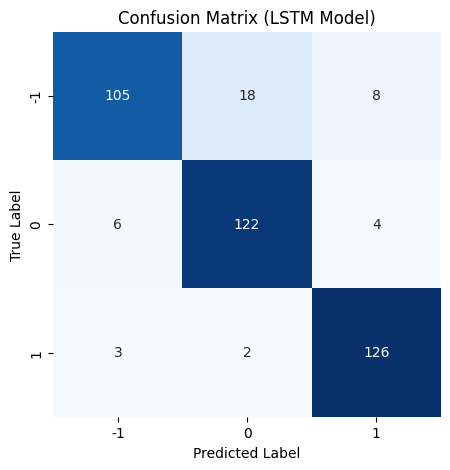

In [55]:
# Menghitung confusion matrix untuk kedua model
cm_lstm = confusion_matrix(y_true, y_pred_lstm)

# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_lstm, "Confusion Matrix (LSTM Model)")

Output

In [57]:
# Panggil dataset: memuat dataset yang akan digunakan untuk prediksi
full_data = pd.read_csv('../../../../Data/3. EDA/clean-eda_.csv')

# Prediksi pada keseluruhan data: persiapan data untuk prediksi
sequences_full = tokenizer.texts_to_sequences(full_data['text'])  # Mengubah teks menjadi urutan token
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)  # Melakukan padding pada urutan agar panjangnya sama

# Melakukan prediksi pada keseluruhan data menggunakan model LSTM
yhat_full_lstm = model_lstm.predict(x_full_seq)

# Konversi prediksi ke label kelas: memperoleh label kelas dari prediksi model
yhat_full_lstm_classes = np.argmax(yhat_full_lstm, axis=1) - 1

# Tambahkan kolom baru ke DataFrame: menyimpan hasil prediksi ke dalam dataset
full_data['predicted_sentiment'] = yhat_full_lstm_classes

# Menampilkan 10 baris pertama dari dataset
full_data.head(10)

"""
Bagian ini berfungsi untuk mempersiapkan dataset, melakukan prediksi menggunakan model LSTM, 
mengubah prediksi probabilitas menjadi label kelas, dan menyimpan hasil prediksi ke dalam dataset. 
Kemudian, menampilkan 10 baris pertama dari dataset untuk verifikasi.

150/150 [==============================] - 22s 143ms/step


,video_id,raw,text,predicted_sentiment
0,video1,Baiknya bagaimana menurut kalian?,baik bagaimana turut kalian,0
1,video1,Betul dok betul dok,betul dok betul dok,0
2,video1,Betul dok mungkin efek sa di,betul dok mungkin efek sa,0
3,video1,"Bpom aneh, tidak kerja. Kenapa ko seperti itu.",bpom aneh kerja kok itu,-1
4,video1,Benar banget anak sy aj hrs sirup minum obatny...,benar banget anak aku saja harus sirup minum o...,0
5,video1,Makasih ilmunya dokter semoga berkah🥰🥰🥰🥰,terima kasih ilmu dokter semoga berkah,1
6,video1,Dok tempra gimana? Soalnya anakku kalau demam ...,dok tempra bagaimana soal anak kalau demam kas...,0
7,video1,BIOSOLFON KIDS AMAN GAK KAK,biosolfon kids aman enggak kak,0
8,video1,apa kurang ilmu ya dok,apa kurang ilmu dok,0
9,video1,Cara media massa cari uang.... Memainkan keres...,cara media massa cari uang main resah bingung ...,-1


In [58]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-LSTM.csv", index=False)